In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/shadi_project/src/notebooks/

[Errno 2] No such file or directory: '/content/drive/MyDrive/shadi_project/src/notebooks/'
/content


In [5]:
cd /content/drive/MyDrive/project_road_segmentation/shadi_project/src/notebooks

/content/drive/MyDrive/project_road_segmentation/shadi_project/src/notebooks


# Imports

In [7]:
# Reloading
%load_ext autoreload
%autoreload 2

import random
import os, sys, time
sys.path.append('..')
#from config import *
import numpy as np
import torch.nn.functional as F
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import datetime
#from optim import lr_sheduler
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from helpers.build_dataset import RoadDataset, TestSet
from helpers.training import training2
from models.model_UNet_alpha import UNetAlpha
#from models.uNet import UNet, UNet_post_processing
from models.model_UNet_beta import UNetBeta
from models.model_UNet_gamma import UNetGamma
#from models.model_Unet import UNet
#from models.model_MultiResUNet import MultiResUNet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define constants and paths

In [ ]:
TRAIN_IMG_PATH = '../../data/training/images/'
TRAIN_LABEL_PATH = '../../data/training/groundtruth/'
TEST_IMG_PATH = '../../data/test_set_images/'

BATCH_SIZE = 64
NUM_EPOCHS = 5

PATCH_SIZE = 80
OVERLAP = True
OVERLAP_AMOUNT = 40

TESTING_SIZE = 50
DATA_SIZE = 100
TRAINING_SIZE = 95
VALIDATION_SIZE = DATA_SIZE - TRAINING_SIZE

MODE = 'TRAIN'
SEED = 42

In [ ]:
def fix_seed(SEED):
    np.random.seed(SEED) # cpu vars
    torch.manual_seed(SEED) # cpu  vars
    random.seed(SEED) # Python
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) # gpu vars
    torch.backends.cudnn.deterministic = True  #needed
    torch.backends.cudnn.benchmark = False

# Train model 

In [ ]:
fix_seed(SEED)

if MODE == 'TRAIN':
    # Get train and validation indices
    indices = np.random.permutation(np.arange(1, DATA_SIZE + 1))
    train_indices = indices[:TRAINING_SIZE]
    validation_indices = indices[TRAINING_SIZE:]
    
    # Build training and validation datasets and dataloaders
    train_set = RoadDataset(TRAIN_IMG_PATH, TRAIN_LABEL_PATH, train_indices, PATCH_SIZE, TRAINING_SIZE, OVERLAP_AMOUNT, augmentation=True)
    validation_set = RoadDataset(TRAIN_IMG_PATH, TRAIN_LABEL_PATH, validation_indices, PATCH_SIZE, VALIDATION_SIZE, augmentation=False)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(validation_set, 1, shuffle=False)
    # Define model and loss 
    #vggmodel = VGGNet()
    #fcnmodel = FCNs(pretrained_net=vggmodel)

    model = UNet()
    criterion = torch.nn.BCEWithLogitsLoss().cuda() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model and output best epoch result
    model_name = datetime.datetime.now().strftime('unet_%d-%m-%y-%H_%M_weights_patch80_depth256_batch64_waug4590')
    model, train_losses, val_losses, score = training2(50, model, criterion, optimizer, train_loader, validation_loader, model_name)

    # Save best model with date
    torch.save(model.state_dict(), f'{model_name}_{score:03}.pth')

Loaded images
Loaded labels
Loaded images
Loaded labels
-------------
Starting training process for 50 epochs : 
-------------

Epoch 0 <3.3e+02> : Training loss = 0.658 - Validation loss = 0.693 --- F1 score = 0.9043 - acc = 0.8984 

Epoch 1 <3.2e+02> : Training loss = 0.638 - Validation loss = 0.698 --- F1 score = 0.9004 - acc = 0.8911 

Epoch 2 <3.2e+02> : Training loss = 0.635 - Validation loss = 0.707 --- F1 score = 0.9492 - acc = 0.9489 

Epoch 3 <3.2e+02> : Training loss = 0.636 - Validation loss = 0.693 --- F1 score = 0.9135 - acc = 0.9127 

Epoch 4 <3.2e+02> : Training loss = 0.644 - Validation loss = 0.693 --- F1 score = 0.9547 - acc = 0.9528 

Epoch 5 <3.2e+02> : Training loss = 0.634 - Validation loss = 0.693 --- F1 score = 0.9515 - acc = 0.9511 

Epoch 6 <3.2e+02> : Training loss = 0.63 - Validation loss = 0.718 --- F1 score = 0.9547 - acc = 0.9546 

Epoch 7 <3.2e+02> : Training loss = 0.633 - Validation loss = 0.698 --- F1 score = 0.9565 - acc = 0.9568 

Epoch 8 <3.2e+02>

KeyboardInterrupt: ignored

# Test dataset and create submission file

In [ ]:
def labels_to_patches(image, img_size, p_size, threshold):
    """
    Transform pixel-wise label image, to patch-wise label image.
    """
    patch_prediction_values = torch.zeros(1444).cuda()
    index=0
    #for image in images:
    for i in range(0, img_size, p_size):
        for j in range(0, img_size, p_size):    
            mean = torch.mean(image[j : j+p_size, i : i+p_size])
            if mean > threshold: 
                patch_prediction_values[index] = 1
            index += 1
    return  patch_prediction_values 

In [ ]:
def labels_to_patches_display(image, img_size, p_size, threshold):
    """
    Transform pixel-wise label image, to patch-wise label image.
    """
    patches_for_display = torch.zeros([img_size, img_size]).cuda()
    patch_prediction_values = torch.zeros(1444).cuda()
    #for image in images:
    for i in range(0, img_size, p_size):
        for j in range(0, img_size, p_size):    
            mean = torch.mean(image[i : i+p_size, j : j+p_size])
            if mean > threshold: 
                patches_for_display[i : i+p_size, j : j+p_size] = 1
            else: 
                patches_for_display[i : i+p_size, j : j+p_size] = 0
    return patches_for_display

In [ ]:
import pandas as pd
fix_seed(SEED)

# Load model from weights file
best_model = UNetBeta().cuda()
best_model.eval()
best_model.load_state_dict(torch.load('models/Final_UNetGamma_patch80_depth256_batch64_epochs55.pth'))

# Build test set and test loader
test_indices = np.arange(1, TESTING_SIZE + 1)
test_set = TestSet(TEST_IMG_PATH, test_indices, 608)
test_loader = DataLoader(test_set, 1, shuffle=False)

# Test model
index = 0
output_predictions = torch.zeros(1444*50).cuda()
output_images = torch.zeros(50, 608, 608).cuda()
i = 0
for batch in test_loader: # a batch corresponds to all patches from a single image
    batch = batch.cuda()
    output = best_model(batch).squeeze()#.round()
    output_predictions[index:index+1444] = labels_to_patches(output, 608, p_size=16, threshold=0.2)
    output_images[i] = labels_to_patches_display(output, 608, p_size=16, threshold=0.2)
    index += 1444

# Create submission file
ids = []
for i in range(1, TESTING_SIZE+1):
    for j in range(0, 608, 16):
        for k in range(0, 608, 16):
            ids.append(f'{i:03}_{j}_{k}')

dic = {'id': ids, 
        'prediction': output_predictions.cpu().numpy()}
filename = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_submission.csv')
pd.DataFrame(data = dic).to_csv(filename, index=False)

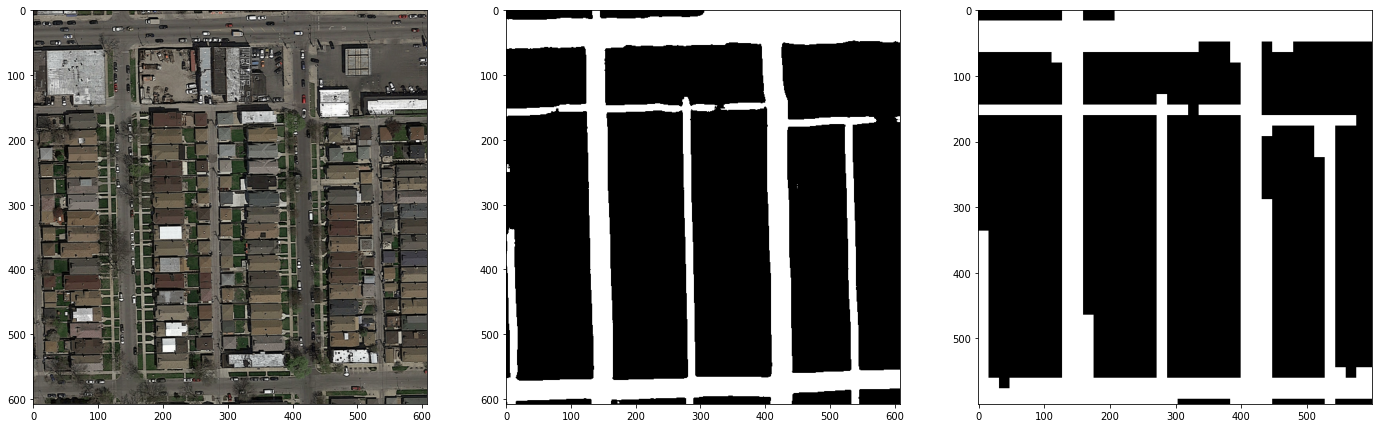

In [ ]:
showloader = DataLoader(test_set, 1, shuffle=False)
original = np.transpose(iter(showloader).next().squeeze().numpy(), (1, 2, 0))
image = iter(showloader).next().cuda()
#gt_image = iter(gt_loader).next().cuda()

output_model = best_model(image).squeeze().round()
output_patches = labels_to_patches_display(output_model, 600, 16, 0.25).cpu().detach().numpy()
output_model_cpu = output_model.cpu().detach().numpy()
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(original)
ax[1].imshow(output_model_cpu, cmap='gray')
ax[2].imshow(output_patches, cmap='gray')